### Task and data description

Требуется по описанию компьютерной игры предсказать победителя.

Игра ведётся в режиме 1 на 1 двумя игроками, они названы игрок 1 и игрок 2, но этот порядок не даёт никакому из игроков преимущества (это не пошаговая игра, а игра в режиме реального времени, поэтому нет и преимущества первого хода). Игроки управляют юнитами (которые игроки выбирают, прокачивают перед сражением). 

В армии каждого игрока 8 разных юнитов, состав армии фиксирован на время сражения, но его можно менять перед сражением. Исход игры зависит от случая, мастерства игроков и способности юнитов взаимодействовать и уничтожать юниты противника.

Описание данных

    train.csv - обучающая выборка с целевым признаком
    test.csv - тестовая без целевого
    sample_submission.csv - пример решения

Названия признаков

    X0 - режим (тренировка, бой, бой на чемпионате и т.п.)
    X1 - игрок 1 (id)
    X2 - рейтинг игрока 1 до игры (порядковый)
    X3 - игрок 2 (id)
    X4 - рейтинг игрока 2 до игры (порядковый)
    X5 - юнит 1 игрока 1 (ниже описание армий игроков, перечислены id юнитов, описание юнитов не даётся)
    X6 - юнит 2 игрока 1

...

    X12 - юнит 8 игрока 1
    X13 - юнит 1 игрока 2

...

    X20 - юнит 8 игрока 2
    X21 - время игры (порядковый)

Все признаки, которые не помечены как порядковые – категориальные. Целевое значений = 1, если выиграл первый игрок, иначе = 0.

Для генерации файлов необходимо запустить тетрадку  preparing_data (работает довольно долго)

### Solution description

#### PART1: Data preparation

Основных этапов пять(здесь реализованы 4 и один предподсчитывается в главном кернеле). 

<b>Первый этап</b>, это разделение датастета, на TEST, STAT и  TRAIN(TRAIN+VAL) выборки.


<b>STAT</b> датафрейм нужен для подсчёта статистик, он не используется для обучения или валидации. Отдельный независимый датафрейм помогает избежать оверфита.
<b>TEST</b> нужен для локальной валидации. 
<b>TRAIN</b> разделяется в ходе обучения на 5 фолдов(4  TRAIN и 1 VAL) с уcреднением результатов прогнозов. 

Соотношение следующее:

<ul>
    <li><b>TRAIN</b> 45% </li>
    <li><b>TEST</b> 15%  </li>
    <li><b>STAT</b> 40%  </li>
</ul>



<b>Второй этап</b> это энкодинг категориальных признаков. Используется WOE-encoding для признаков X1, X3, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20 и target encoding на STAT датафрейме(считается в главном кернеле)(https://heartbeat.fritz.ai/hands-on-with-feature-engineering-techniques-encoding-categorical-variables-be4bc0715394).

<b>Третий этап</b> это следующий подход. Если есть некая комбинация игроков, состоящая из n юнитов(в данном случае n=8), то можно сделать предположение о том, что если они уже играли и мы знаем результат этой команды(в STAT датафрейме), то найдя их в трейне или тесте, можно предположить, что они сыграют также и добавить результаты в качестве фичи. (признаки res_1, res_2 по командам соответственно)

Можно уменьшить n до 6-7 в дальнейшем и использовать в качестве доп. фичи.


<b> Четвертый этап (подсчёт в главном кернеле)</b> Идея состоит в следующем. На STAT датафрейме подсчитывается квадратная матрица, где значение в ячейке i, j это количетсво побед юнита i над юнитом j. В качестве допущения предполагается, что все юниты победившей команды одержали победу над юнитами противника. Далее высчитывается т.н. сила команды (признаки strength_1, strength_2), по следующему принципу. Если количество побед одного юнита, над другим больше чем на n процентов(наприме юнит 33 выиграл на 5% битв у юнита 22, при n=5), то юнит считается более сильным. Сила команды это количество сильных юнитов. То есть всего 64 пары противников, из них некоторое количетсво сильных юнитов в одной команде и в другой. 


<b> Пятый этап</b> 

Есть признак X21 - время игры (порядковый). Поскольку в тестовый сет взяты не последние игры игрока, а произвольные, то можно воспользоваться этим и протащить в прошлое, некоторые статистики будущего, что позволит на основе разности рейтингов и прочих характеристик, понять, как закончилась игра. Также можно получить статистику из прошлого в качестве фичей. 


Рекомендуется скачать генерируемые файлы по ссылке т.к. генерация может занять от 15-20 часов до суток(WOE'шники долго генерируются). https://drive.google.com/drive/folders/1VJDOL54xDrS8iQ5a4TqjXDnvmQfd_ae2?usp=sharing и поместить две папки в папку с кернелом.


#### PART2: Pipeline preparation

При загрузке датафреймов в память их размер сжимается(чтобы не занимать много памяти).

В конечной итерации использовался только lightgbm с усреднением по пяти фолдам. 

Большая часть подготовленных данных импортируется после работы скрипта preparing_data. 


Из того, что зашло сильнее всего:
<ul>
<li>
        ликовая информация, связанная с изменением рейтинга и других статов(+история таких измений)
        признаки с ключевыми словами <b>before</b>, <b>after</b>, <b>diff</b>; 
    </li>
    
<li> информация, о уже отыгранных матчах командой с подобным составом, признаки <b>res_1</b>, 
        <b>res_2</b> </li>
    
    
<li> сила команд, признаки <b>strength_1</b>, <b>strength_2</b>; </li>
    
<li> разности характеристик игроков. </li>
    
<li> одиночные противостояния некоторых юнитов, признаки с ключевым словом <b>gegen </b>. Этот признак является отношением побед первого игрока над вторым; </li>

<li> энкодинги </li>
</ul>

Меньше всего:
<ul>
<li> Использование нейронок </li>
    
        
</ul>



Что не успел проверить/сделать:

<ul>
<li>
Иследовать данные пользователя внутри одного временного периода игр(чтобы восстановить порядок внутри периода).
</li>
</ul>

### Result

<ul>
    <li>Place - <b>4th</b></li>
    <li>Public leaderboard - <b>0.52554</b></li>
    <li>Private leaderbord - <b>0.53041</b></li>
    
</ul>

### Contacts

Telegram: @do_what_thou_wilt  (по любым попросам, касающимся решения)

### Libraries

In [1]:
#!pip install keras==2.0.8
#!pip install tensorflow==1.13.1
#!pip install lightgbm==3.1.1

In [4]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb


import tqdm
import matplotlib.pyplot as plt
import pickle 


import seaborn as sns
import warnings
from tqdm.auto import tqdm 

import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import joblib

import itertools
import tensorflow as tf

import warnings

from datetime import datetime as dt
from datetime import datetime, date

import random
import torch

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [5]:
def seed_everything(seed=1234):
    
    """
    Seed for training and predictions.
    """
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(1488)

### Define some consts and settings

In [6]:
DATA_DIR = "./data/"
OUTPUT_DIR = "./output/"

MODEL_DIR = "./models/"
ADDING_DATA = "./adding_data/"

In [7]:
pd.set_option('display.max_columns', None)

tqdm.pandas()

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Import data

In [9]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train_split.csv'))
train = reduce_mem_usage(train)

val = pd.read_csv(os.path.join(DATA_DIR, 'test_split.csv'))
val = reduce_mem_usage(val)

stat = pd.read_csv(os.path.join(DATA_DIR, 'stat_split.csv'))
stat = reduce_mem_usage(stat)

test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test = reduce_mem_usage(test)

sub = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
sub = reduce_mem_usage(sub) 

_tmp = pd.read_csv(os.path.join(ADDING_DATA, 'shifter_full_4_all.csv'))
_tmp = reduce_mem_usage(_tmp) 


_tmp_train = pd.read_csv(os.path.join(ADDING_DATA, 'shifter_full_4_all_for_train.csv'))
_tmp_train = reduce_mem_usage(_tmp_train) 



Memory usage of dataframe is 299.35 MB
Memory usage after optimization is: 56.13 MB
Decreased by 81.2%
Memory usage of dataframe is 99.78 MB
Memory usage after optimization is: 18.71 MB
Decreased by 81.2%
Memory usage of dataframe is 266.09 MB
Memory usage after optimization is: 49.89 MB
Decreased by 81.2%
Memory usage of dataframe is 159.38 MB
Memory usage after optimization is: 30.32 MB
Decreased by 81.0%
Memory usage of dataframe is 13.86 MB
Memory usage after optimization is: 5.20 MB
Decreased by 62.5%
Memory usage of dataframe is 5107.37 MB
Memory usage after optimization is: 1438.58 MB
Decreased by 71.8%
Memory usage of dataframe is 4100.21 MB
Memory usage after optimization is: 1154.89 MB
Decreased by 71.8%


In [10]:
_tmp = _tmp[['X0', 'X1', 'X2', 'X3', 'X4', 'X21', 'target', 'target_before_1',
       'X21_before_1', 'X2_before_1', 'X4_before_1', 'X0_before_1',
       'target_before_2', 'X21_before_2', 'X2_before_2', 'X4_before_2',
       'X0_before_2', 'target_before_3', 'X21_before_3', 'X2_before_3',
       'X4_before_3', 'X0_before_3', 'target_before_4', 'X21_before_4',
       'X2_before_4', 'X4_before_4', 'X0_before_4', 'target_after_1',
       'X21_after_1', 'X2_after_1', 'X4_after_1', 'X0_after_1',
       'target_after_2', 'X21_after_2', 'X2_after_2', 'X4_after_2',
       'X0_after_2', 'target_after_3', 'X21_after_3', 'X2_after_3',
       'X4_after_3', 'X0_after_3', 'target_after_4', 'X21_after_4',
       'X2_after_4', 'X4_after_4', 'X0_after_4', 'X21_diff_before_1',
       'X2_diff_before_1', 'X4_diff_before_1', 'X0_same_before_1',
       'X21_diff_before_2', 'X2_diff_before_2', 'X4_diff_before_2',
       'X0_same_before_2', 'X21_diff_before_3', 'X2_diff_before_3',
       'X4_diff_before_3', 'X0_same_before_3', 'X21_diff_before_4',
       'X2_diff_before_4', 'X4_diff_before_4', 'X0_same_before_4',
       'X21_diff_after_1', 'X2_diff_after_1', 'X4_diff_after_1',
       'X0_same_after_1', 'X21_diff_after_2', 'X2_diff_after_2',
       'X4_diff_after_2', 'X0_same_after_2', 'X21_diff_after_3',
       'X2_diff_after_3', 'X4_diff_after_3', 'X0_same_after_3',
       'X21_diff_after_4', 'X2_diff_after_4', 'X4_diff_after_4',
       'X0_same_after_4', 'target_before_mean', 'target_after_mean']]


_tmp_train = _tmp_train[['X0', 'X1', 'X2', 'X3', 'X4', 'X21', 'target', 'target_before_1',
       'X21_before_1', 'X2_before_1', 'X4_before_1', 'X0_before_1',
       'target_before_2', 'X21_before_2', 'X2_before_2', 'X4_before_2',
       'X0_before_2', 'target_before_3', 'X21_before_3', 'X2_before_3',
       'X4_before_3', 'X0_before_3', 'target_before_4', 'X21_before_4',
       'X2_before_4', 'X4_before_4', 'X0_before_4', 'target_after_1',
       'X21_after_1', 'X2_after_1', 'X4_after_1', 'X0_after_1',
       'target_after_2', 'X21_after_2', 'X2_after_2', 'X4_after_2',
       'X0_after_2', 'target_after_3', 'X21_after_3', 'X2_after_3',
       'X4_after_3', 'X0_after_3', 'target_after_4', 'X21_after_4',
       'X2_after_4', 'X4_after_4', 'X0_after_4', 'X21_diff_before_1',
       'X2_diff_before_1', 'X4_diff_before_1', 'X0_same_before_1',
       'X21_diff_before_2', 'X2_diff_before_2', 'X4_diff_before_2',
       'X0_same_before_2', 'X21_diff_before_3', 'X2_diff_before_3',
       'X4_diff_before_3', 'X0_same_before_3', 'X21_diff_before_4',
       'X2_diff_before_4', 'X4_diff_before_4', 'X0_same_before_4',
       'X21_diff_after_1', 'X2_diff_after_1', 'X4_diff_after_1',
       'X0_same_after_1', 'X21_diff_after_2', 'X2_diff_after_2',
       'X4_diff_after_2', 'X0_same_after_2', 'X21_diff_after_3',
       'X2_diff_after_3', 'X4_diff_after_3', 'X0_same_after_3',
       'X21_diff_after_4', 'X2_diff_after_4', 'X4_diff_after_4',
       'X0_same_after_4', 'target_before_mean', 'target_after_mean']]

In [11]:
data_woe_X1 = pd.read_csv(os.path.join(ADDING_DATA, "woe_X1.csv"))[['Value', 'WoE', 'IV']]
data_woe_X3 = pd.read_csv(os.path.join(ADDING_DATA, "woe_X3.csv"))[['Value', 'WoE', 'IV']]

In [12]:
data_woe_X1 = reduce_mem_usage(data_woe_X1) 
data_woe_X3 = reduce_mem_usage(data_woe_X3) 


Memory usage of dataframe is 11.20 MB
Memory usage after optimization is: 3.73 MB
Decreased by 66.7%
Memory usage of dataframe is 11.11 MB
Memory usage after optimization is: 3.70 MB
Decreased by 66.7%


# Model 

In [13]:
def baseline_model(input_size):
    
    """
    Simple neural network model
    """
    
    model = Sequential()
    model.add(Dense(200, input_dim=input_size, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [18]:
class Solution:
    def __init__(self, train, test, val, stat, make_lgb, make_nn):
        
        
        
        self.make_lgb = make_lgb
        self.make_nn = make_nn
        self.matrix_win = [[0 for i in range(102)] for j in range(102)]
        self.matrix_defeated = [[0 for i in range(102)] for j in range(102)]
                
        self.full_set = self.load_teams()
        
        
        
        self.train_df, self.val_df, self.stat_df, self.test_df = self.preprocessing(train, test, val, stat)
        
       
    def load_teams(self):
        """
        Загрузка данных о статистике матчей отсортированных юнитов
        
        """
        with open('./adding_data/teams.pickle', 'rb') as handle:
            full_set = pickle.load(handle)
        return full_set

            
    
    def find_sim(self, x):
        """
        Поиск команд с похожими юнитами
        """
        res_1 = -1
        res_2 = -1

        team_1 = [int(i) for i in sorted(x[6:14].tolist()) ]
        team_2 = [int(i) for i in sorted(x[14:22].tolist())]
        global full_set

        key_1 = (team_1[0], team_1[1], team_1[2], team_1[3], team_1[4], team_1[5], team_1[6], team_1[7]) 
        key_2 = (team_2[0], team_2[1], team_2[2], team_2[3], team_2[4], team_2[5], team_2[6], team_2[7]) 

        if key_1 in self.full_set.keys():
            res_1 =  np.log2((self.full_set[key_1]['count'] - self.full_set[key_1]['sum'])/ max(self.full_set[key_1]['sum'], 1))

        if key_2 in self.full_set.keys():
            res_2 = np.log2(max(self.full_set[key_2]['count'] - self.full_set[key_2]['sum'], 1)/max(self.full_set[key_2]['sum'], 1))

        return res_1, res_2
    
        

    def find_strength(self, x, percent, window):
        
        """
        Функция возвращает силу первой и второй команды и их разницу. 
        
        Параметр percent показывает наскольк юнит должен быть сильнее в %. Window, 
        это окно между юзерами(диапазон просмотра для текущего юнита)
        """
        
        player_1 = x[6:14].tolist()
        player_2 = x[14:22].tolist()

        first_team = 0
        second_team = 0


        for index_i, i in enumerate(player_1):
            for index_j, j in enumerate(player_2):


                strength_1 = self.matrix_win[int(i)][int(j)]
                strength_2 = self.matrix_win[int(j)][int(i)]

                diff = (strength_1 + strength_2)/2

                diff *= percent
                #print(strength_1, strength_2, diff)
                if (strength_1 - diff >= strength_2) and (abs(index_i - index_j) <= window):
                    first_team +=1
                if (strength_2 - diff >= strength_1) and (abs(index_i - index_j) <= window):
                    second_team +=1

        return first_team, second_team, first_team - second_team    


    def calculate_hero(self, x):
        
        """
        Предподсчёт силы героев
        """
        
        player_1 = x[6:14].tolist()
        player_2 = x[14:22].tolist()

        if x['target'] == 1:
            for i in player_1:
                for j in player_2:
                    self.matrix_win[i][j] +=1
                    self.matrix_defeated[j][i] +=1
        else:
            for i in player_2:
                for j in player_1:
                    self.matrix_win[i][j] +=1
                    self.matrix_defeated[j][i] +=1


    def get_features(self, df, stat, _tmp):

        """
        Главная функция для подсчёта статистик.
        
        """
        
        #разность рейтингов
        df['rate_diff'] = df['X2'] - df['X4']
        #target encoding
        df = pd.merge(df,  stat[['X1', 'target']].groupby(['X1']).mean()\
          .reset_index().rename(columns={"X1": "X1","target": "target_per_users_1"}), how='left', left_on='X1', right_on='X1')

        df = pd.merge(df,  stat[['X3', 'target']].groupby(['X3']).mean()\
          .reset_index().rename(columns={"X3": "X3","target": "target_per_users_3"}), how='left', left_on='X3', right_on='X3')

        #добавление статистики из прошлого и будущего
        
        df = pd.merge(df, _tmp.drop(['target'], axis=1), how='left', left_on=[ 'X0', 'X1', 'X2', 'X3', 'X4', 'X21' ],
                      right_on=[ 'X0', 'X1', 'X2', 'X3', 'X4', 'X21' ])
        ## WOE Encoding
        df = pd.merge(df, data_woe_X1.rename(columns={"Value": "Value_X1","WoE": "Woe_X1", "IV":"IV_X1"}), how='left', left_on='X1', right_on='Value_X1')
        df = pd.merge(df, data_woe_X3.rename(columns={"Value": "Value_X3","WoE": "Woe_X3", "IV":"IV_X3"}), how='left', left_on='X1', right_on='Value_X3')
        
        # Похожиие команды
        df['res_1'], df['res_2'] = zip(*df.progress_apply(lambda x: self.find_sim(x), axis=1))

        # Сила игроков
        df['strength_1'], df['strength_2'], df['diff'] = \
         zip(*df.progress_apply(lambda x: self.find_strength(x, 0.05, 2), axis=1))
        
        # 1 на 1
        df['1_hero_gegen_1_hero'] = df[['X5', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['1_hero_gegen_2_hero'] = df[['X5', 'X14']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)

        df['2_hero_gegen_1_hero'] = df[['X6', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['2_hero_gegen_2_hero'] = df[['X6', 'X14']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['3_hero_gegen_1_hero'] = df[['X7', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['3_hero_gegen_2_hero'] = df[['X7', 'X14']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['3_hero_gegen_3_hero'] = df[['X7', 'X15']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['3_hero_gegen_4_hero'] = df[['X7', 'X16']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)

        df['4_hero_gegen_1_hero'] = df[['X8', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['4_hero_gegen_2_hero'] = df[['X8', 'X14']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['4_hero_gegen_3_hero'] = df[['X8', 'X15']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['4_hero_gegen_4_hero'] = df[['X8', 'X16']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
            
        df['5_hero_gegen_1_hero'] = df[['X9', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['5_hero_gegen_2_hero'] = df[['X9', 'X14']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['5_hero_gegen_3_hero'] = df[['X9', 'X15']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['5_hero_gegen_4_hero'] = df[['X9', 'X16']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['5_hero_gegen_5_hero'] = df[['X9', 'X17']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['5_hero_gegen_6_hero'] = df[['X9', 'X18']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)

        df['6_hero_gegen_1_hero'] = df[['X10', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        
        df['6_hero_gegen_4_hero'] = df[['X10', 'X16']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['6_hero_gegen_5_hero'] = df[['X10', 'X17']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['6_hero_gegen_6_hero'] = df[['X10', 'X18']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['6_hero_gegen_7_hero'] = df[['X10', 'X19']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)

        df['7_hero_gegen_1_hero'] = df[['X11', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1) 
        
        df['7_hero_gegen_5_hero'] = df[['X11', 'X17']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['7_hero_gegen_6_hero'] = df[['X11', 'X18']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['7_hero_gegen_7_hero'] = df[['X11', 'X19']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['7_hero_gegen_8_hero'] = df[['X11', 'X20']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['8_hero_gegen_1_hero'] = df[['X12', 'X13']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['8_hero_gegen_6_hero'] = df[['X12', 'X18']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['8_hero_gegen_7_hero'] = df[['X12', 'X19']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        df['8_hero_gegen_8_hero'] = df[['X12', 'X20']].progress_apply(lambda x: self.matrix_win[x[0]][x[1]] / max(self.matrix_win[x[1]][x[0]],1), axis=1)
        
        
        # WOE Encodings
        for i in ["X5", "X6", "X7", "X8","X9", "X10","X11", "X12","X13", "X14","X15", "X16","X17", "X18", "X19", "X20"]:
            
            temp = pd.read_csv("./adding_data/woe_{0}.csv".format(i))
            df = pd.merge(df, temp.rename(columns={"Value": "Value_{0}".format(i),
                        "WoE": "Woe_{0}".format(i), "IV":"IV_{0}".format(i)}), 
                        how='left', left_on=i, right_on='Value_{0}'.format(i))
            df.drop([i], axis=1, inplace=True)

        df = df.replace({'res_1': {np.inf: 0, -np.inf: 0}, 
                          'res_2': {np.inf: 0, -np.inf: 0}
                          
                          })
        
        # Filling NA
        df['target_before_1'].fillna(-1, inplace=True)
        df['X21_before_1'].fillna(0, inplace=True)
        df['X2_before_1'].fillna(0, inplace=True)
        df['X4_before_1'].fillna(0, inplace=True)
        df['X0_before_1'].fillna(-1, inplace=True)


        df['target_before_2'].fillna(-1, inplace=True)
        df['X21_before_2'].fillna(0, inplace=True)
        df['X2_before_2'].fillna(0, inplace=True)
        df['X4_before_2'].fillna(0, inplace=True)
        df['X0_before_2'].fillna(-1, inplace=True)


        df['target_before_3'].fillna(-1, inplace=True)
        df['X21_before_3'].fillna(0, inplace=True)
        df['X2_before_3'].fillna(0, inplace=True)
        df['X4_before_3'].fillna(0, inplace=True)
        df['X0_before_3'].fillna(-1, inplace=True)


        df['target_before_4'].fillna(-1, inplace=True)
        df['X21_before_4'].fillna(0, inplace=True)
        df['X2_before_4'].fillna(0, inplace=True)
        df['X4_before_4'].fillna(0, inplace=True)
        df['X0_before_4'].fillna(-1, inplace=True)




        df['target_after_1'].fillna(-1, inplace=True)
        df['X21_after_1'].fillna(0, inplace=True)
        df['X2_after_1'].fillna(0, inplace=True)
        df['X4_after_1'].fillna(0, inplace=True)
        df['X0_after_1'].fillna(-1, inplace=True)


        df['target_after_2'].fillna(-1, inplace=True)
        df['X21_after_2'].fillna(0, inplace=True)
        df['X2_after_2'].fillna(0, inplace=True)
        df['X4_after_2'].fillna(0, inplace=True)
        df['X0_after_2'].fillna(-1, inplace=True)


        df['target_after_3'].fillna(-1, inplace=True)
        df['X21_after_3'].fillna(0, inplace=True)
        df['X2_after_3'].fillna(0, inplace=True)
        df['X4_after_3'].fillna(0, inplace=True)
        df['X0_after_3'].fillna(-1, inplace=True)


        df['target_after_4'].fillna(-1, inplace=True)
        df['X21_after_4'].fillna(0, inplace=True)
        df['X2_after_4'].fillna(0, inplace=True)
        df['X4_after_4'].fillna(0, inplace=True)
        df['X0_after_4'].fillna(-1, inplace=True)
        df.fillna(-1, inplace=True)
        
        
        return df

    def preprocessing(self, train, test, val, stat):
        """
         Предпроцессинг данных
        """
        stat.progress_apply(lambda x: self.calculate_hero(x), axis=1)
        
        train = self.get_features(train, stat,  _tmp_train)

        val = self.get_features(val, stat, _tmp_train)

        test = self.get_features(test, stat, _tmp)

        return train, val, stat, test
    
    
    def prepare_prognosis(self, params):

        
        result = self.train_model(self.train_df, self.val_df, self.test_df, params)
        
        return result
        
    @staticmethod
    def plotImp(model, X , num = 20, fig_size = (40, 20)):

        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns}) 
        plt.figure(figsize=fig_size)
        sns.set(font_scale = 5)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                            ascending=False)[0:num])
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances-01.png')
        plt.show()
        
        

    def merge_and_split(self):

        return train, test

    def train_model(self, train, val, test, params):
        
        
        """
        Тренировка моделей
        """
        
        X = train.drop(['target'],axis=1)
        y = train['target']
        
        test_pred = test.copy()
        val_pred = val.copy()
        
        kf = KFold(n_splits=5, shuffle=True, random_state=1044)

        for index_fold, (train_index, test_index) in enumerate(kf.split(X)):

    
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            y_real_train, y_real_test =  train['target'].iloc[train_index], train['target'].iloc[test_index]
  
            if self.make_lgb:

                hyper_params =  params

                gbm = lgb.LGBMClassifier(**hyper_params)

                gbm.fit(X_train, y_train,
                        eval_set=[(X_test, y_test), (X_train, y_train)],
                        eval_metric='logloss',
                        verbose = 200, 
                        early_stopping_rounds=50)
                
                # сохранение лучшей модели
                joblib.dump(gbm, os.path.join(MODEL_DIR, 'best_model_fold_{0}.pkl'.format(index_fold)))
                gbm = joblib.load(os.path.join(MODEL_DIR, 'best_model_fold_{0}.pkl'.format(index_fold)))
                test_pred['target_{0}'.format(index_fold)] = np.array([i if i > 0 else 0 for i in gbm.predict_proba(test)[:, 1]])
                
                val_pred['target_{0}'.format(index_fold)] = np.array([i if i > 0 else 0 for i in gbm.predict_proba(val.drop(['target'], axis=1))[:, 1]])
                
                self.plotImp(gbm, X, num = 30)
                

                print("LOGLOSS VALUE", log_loss(val['target'], np.array([i if i > 0 else 0 for i in gbm.predict_proba(val.drop(['target'], axis=1))[:, 1]])))
                
                
            else:
                test_pred['target_{0}'.format(index_fold)] = 0
                val_pred['target_{0}'.format(index_fold)] = 0
                
            if self.make_nn:
                

                scaler =  MinMaxScaler()
                X_train=scaler.fit_transform(X_train)
                X_test=scaler.transform(X_test)
                df_pred= scaler.transform(test)
                
                df_val = scaler.transform( val.drop(['target'], axis=1))

                model = baseline_model(X_train.shape[1])
                
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
                mc = ModelCheckpoint(os.path.join(MODEL_DIR, "best_model_fold_{0}.h5".format(index_fold)),
                                     monitor='val_loss', mode='min', verbose=1, save_best_only=True)
                reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, epsilon=1e-4, mode='min')
                model.fit(X_train, y_train,
                          validation_data=(X_test,y_test),nb_epoch=100,batch_size=512, callbacks=[es, mc, reduce_lr_loss])

                model.load_weights(os.path.join(MODEL_DIR, "best_model_fold_{0}.h5".format(index_fold)))
                test_pred['target_nn_{0}'.format(index_fold)] = [i[0] if i[0]>0 else 0 for i in model.predict(df_pred)]
                
                val_pred['target_nn_{0}'.format(index_fold)] = [i[0] if i[0]>0 else 0 for i in model.predict(df_val)]
                print("LOGLOSS VALUE", log_loss(val['target'], np.array([i[0] if i[0]>0 else 0 for i in model.predict(df_val)])))

            else:
                
                test_pred['target_nn_{0}'.format(index_fold)] = 0
                val_pred['target_nn_{0}'.format(index_fold)] = 0

        return test_pred, val_pred

In [19]:
sol = Solution(train, test, val, stat, make_lgb=True, make_nn=False)

  0%|          | 0/1453203 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

/home/eskender/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2


  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/1634852 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/544950 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

  0%|          | 0/908252 [00:00<?, ?it/s]

In [22]:
params = {

                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': ['logloss'],
                'learning_rate': 0.005,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 10,
                'verbose': -1,
                "max_depth": 128,
                "num_leaves": 64,  
                "max_bin": 256,
                
                #"num_iterations": 2000,
                # В оригинале учил на 5
                "num_iterations": 5000,
                "n_estimators": 2000
                }




/home/eskender/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.600402	valid_0's binary_logloss: 0.599826
[400]	training's binary_logloss: 0.582745	valid_0's binary_logloss: 0.582705
[600]	training's binary_logloss: 0.573642	valid_0's binary_logloss: 0.57399
[800]	training's binary_logloss: 0.567683	valid_0's binary_logloss: 0.568428
[1000]	training's binary_logloss: 0.563149	valid_0's binary_logloss: 0.564329
[1200]	training's binary_logloss: 0.559883	valid_0's binary_logloss: 0.561542
[1400]	training's binary_logloss: 0.556723	valid_0's binary_logloss: 0.558818
[1600]	training's binary_logloss: 0.554366	valid_0's binary_logloss: 0.556939
[1800]	training's binary_logloss: 0.552177	valid_0's binary_logloss: 0.555185
[2000]	training's binary_logloss: 0.549929	valid_0's binary_logloss: 0.553362
Did not meet early stopping. Best iteration is:
[2000]	training's binary_logloss: 0.549929	valid_0's binary_logloss: 0.553362


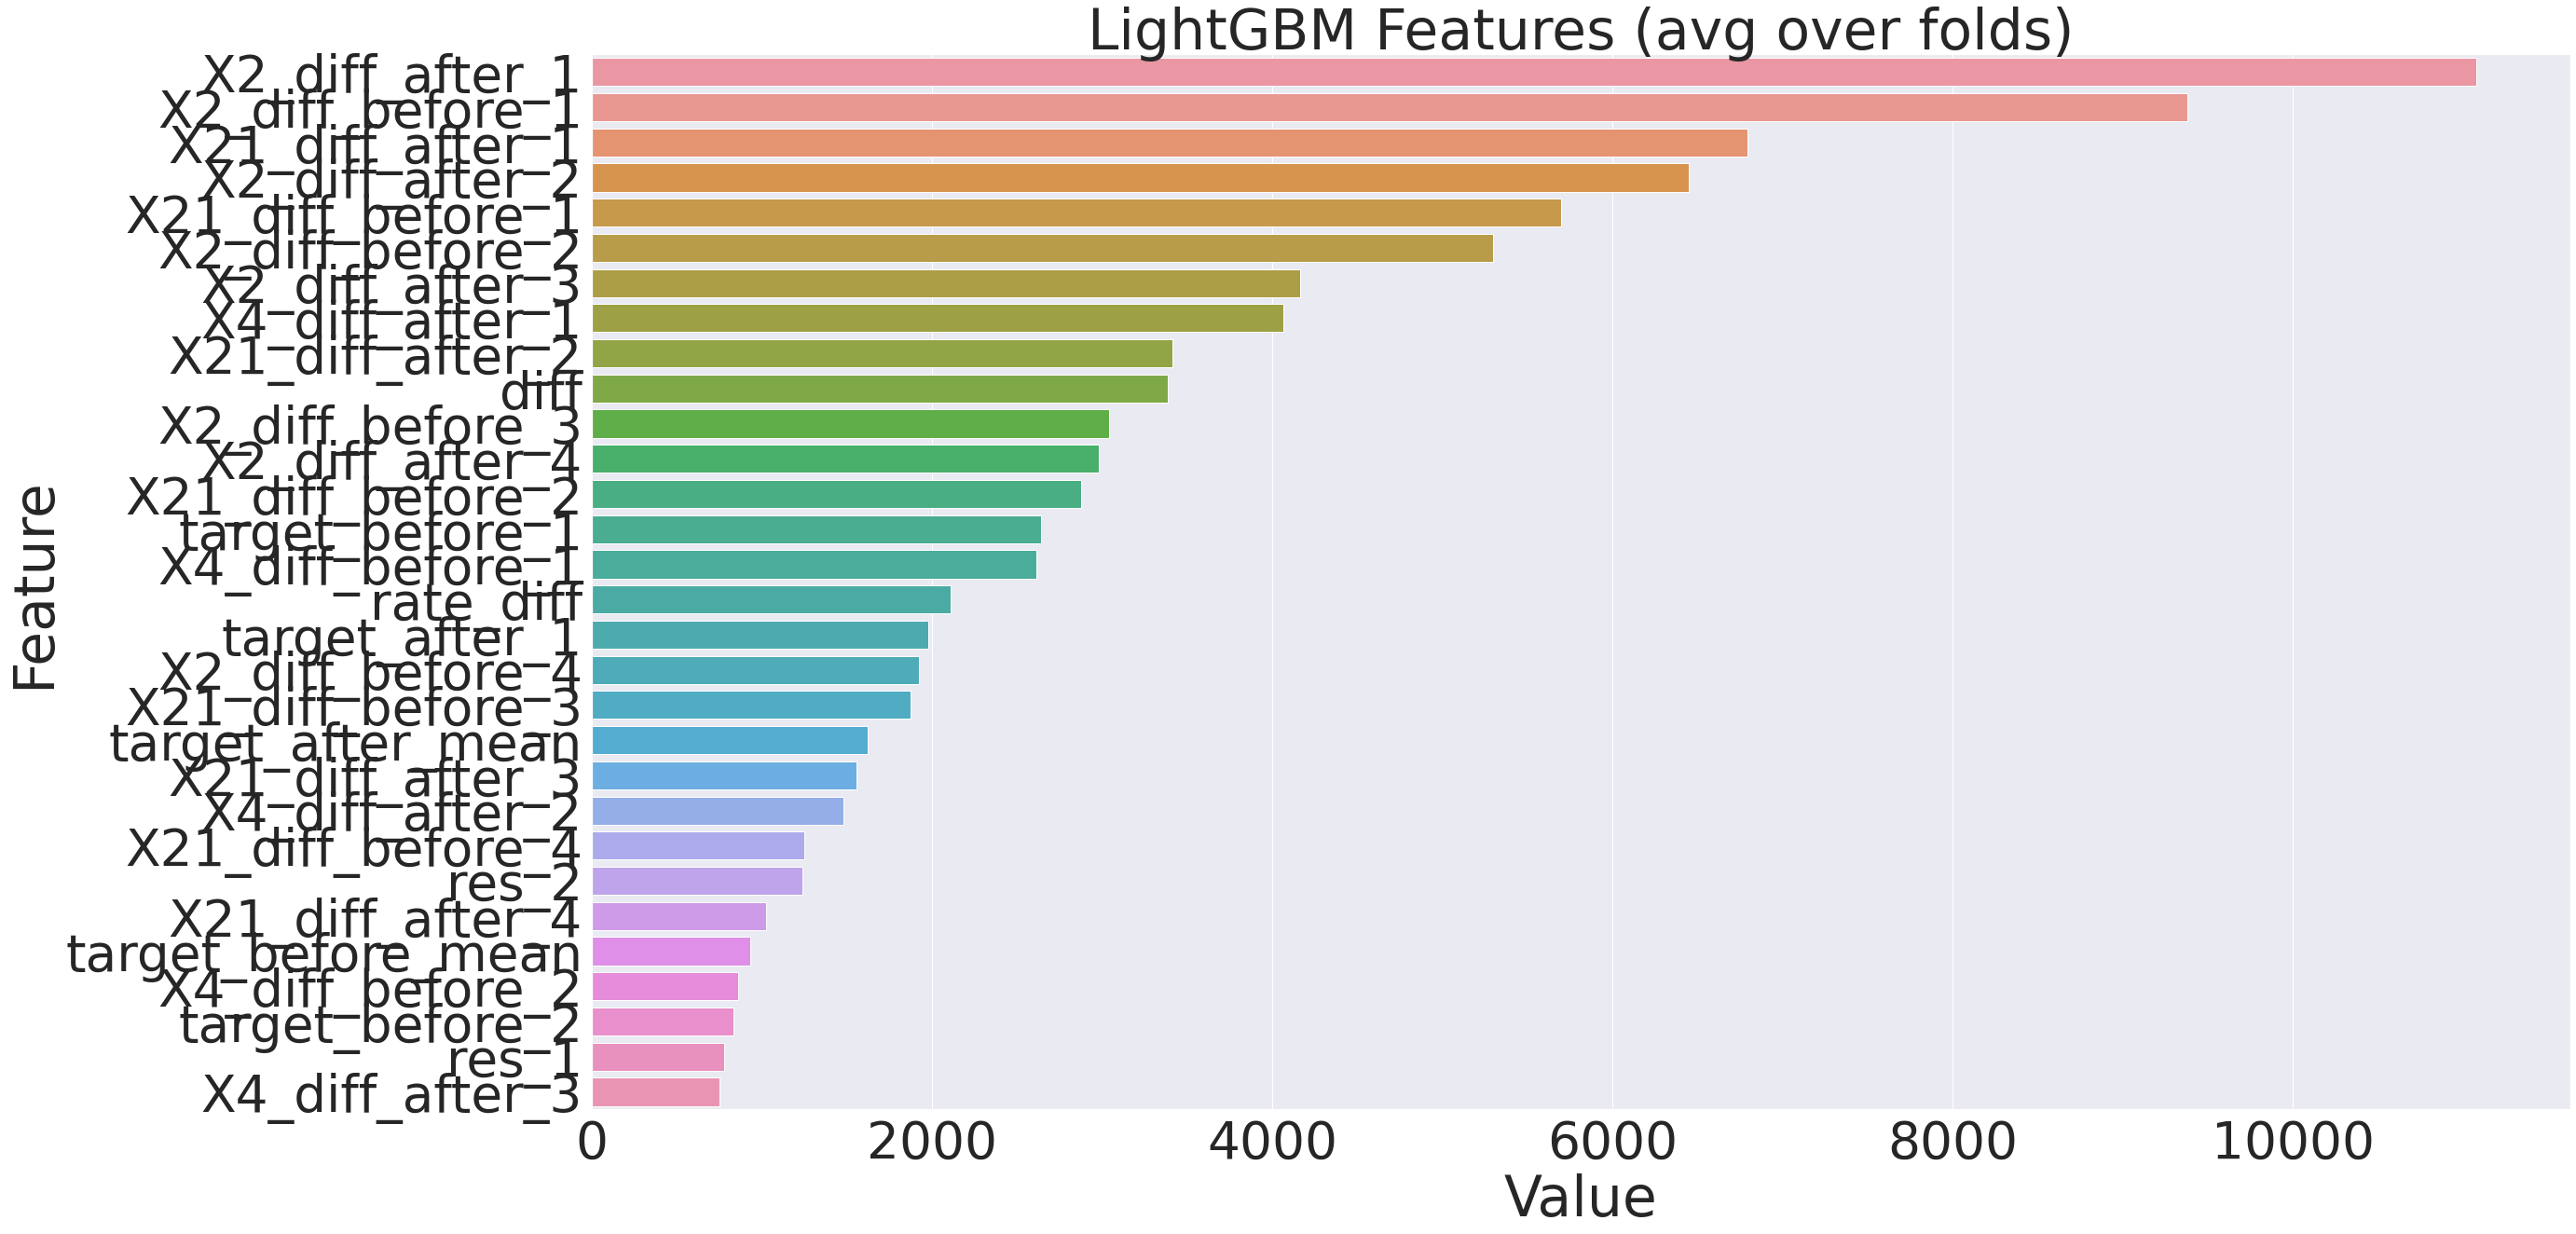

LOGLOSS VALUE 0.5533407234823529


/home/eskender/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.600374	valid_0's binary_logloss: 0.600239
[400]	training's binary_logloss: 0.582682	valid_0's binary_logloss: 0.582885
[600]	training's binary_logloss: 0.573363	valid_0's binary_logloss: 0.573948
[800]	training's binary_logloss: 0.567596	valid_0's binary_logloss: 0.568582
[1000]	training's binary_logloss: 0.562668	valid_0's binary_logloss: 0.564055
[1200]	training's binary_logloss: 0.559655	valid_0's binary_logloss: 0.561517
[1400]	training's binary_logloss: 0.556509	valid_0's binary_logloss: 0.558816
[1600]	training's binary_logloss: 0.553862	val

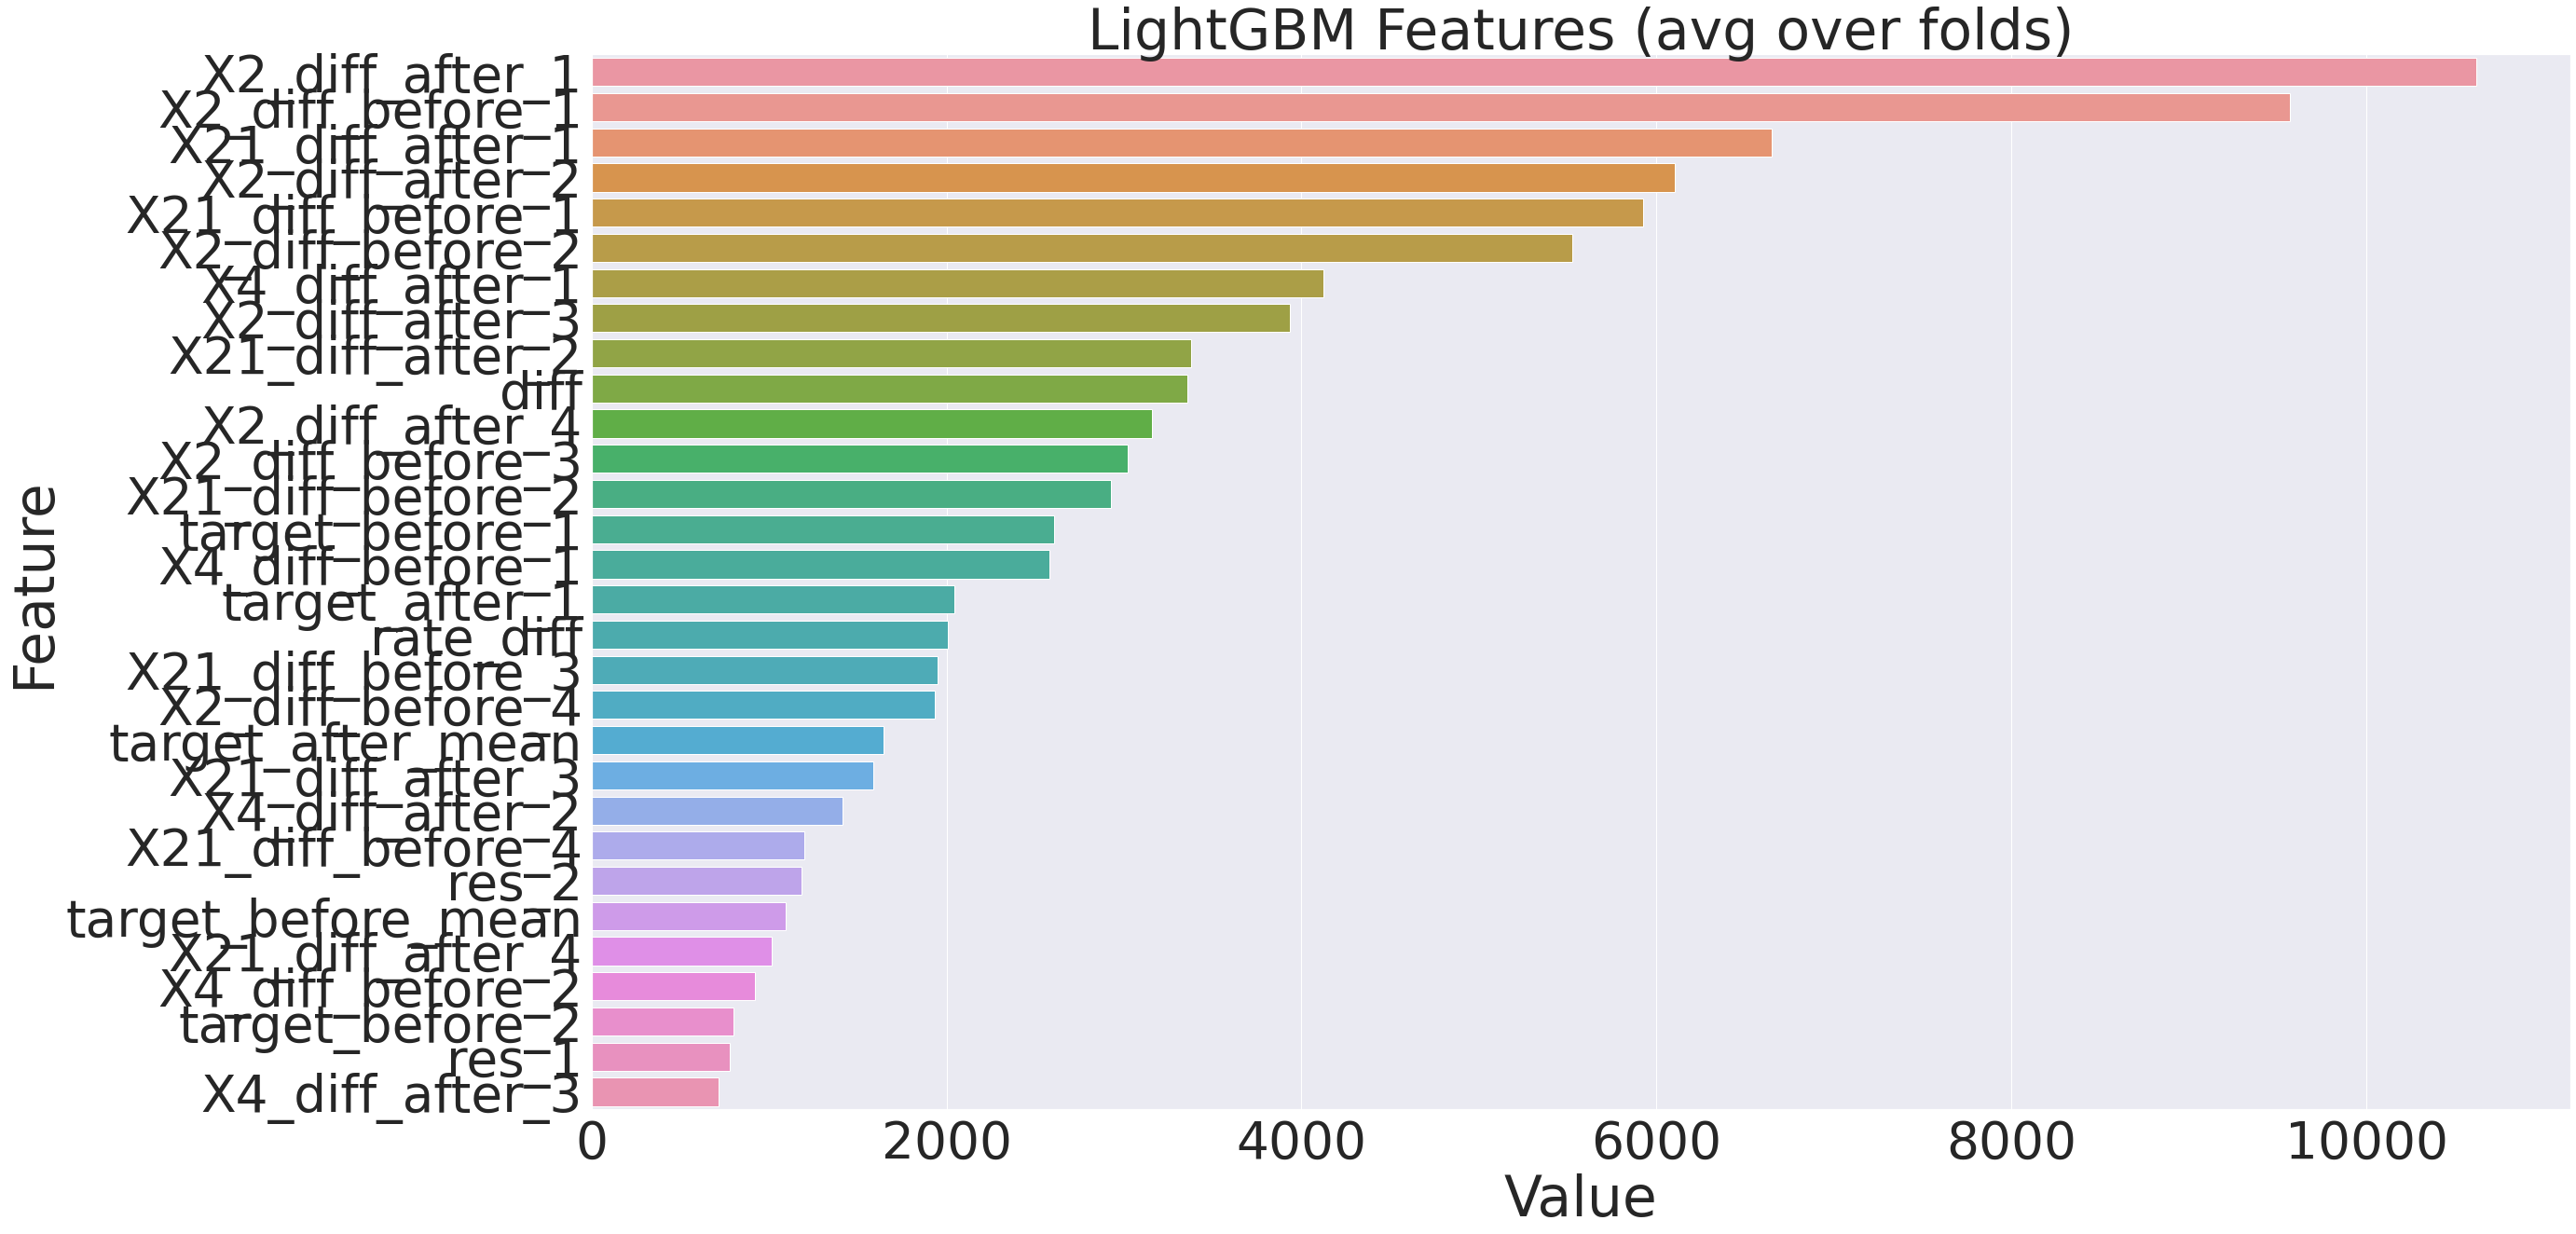

LOGLOSS VALUE 0.552824697009598


/home/eskender/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.600145	valid_0's binary_logloss: 0.60107
[400]	training's binary_logloss: 0.582323	valid_0's binary_logloss: 0.583439
[600]	training's binary_logloss: 0.573029	valid_0's binary_logloss: 0.57437
[800]	training's binary_logloss: 0.567709	valid_0's binary_logloss: 0.569354
[1000]	training's binary_logloss: 0.562905	valid_0's binary_logloss: 0.564853
[1200]	training's binary_logloss: 0.5594	valid_0's binary_logloss: 0.561747
[1400]	training's binary_logloss: 0.55659	valid_0's binary_logloss: 0.559345
[1600]	training's binary_logloss: 0.554353	valid_0'

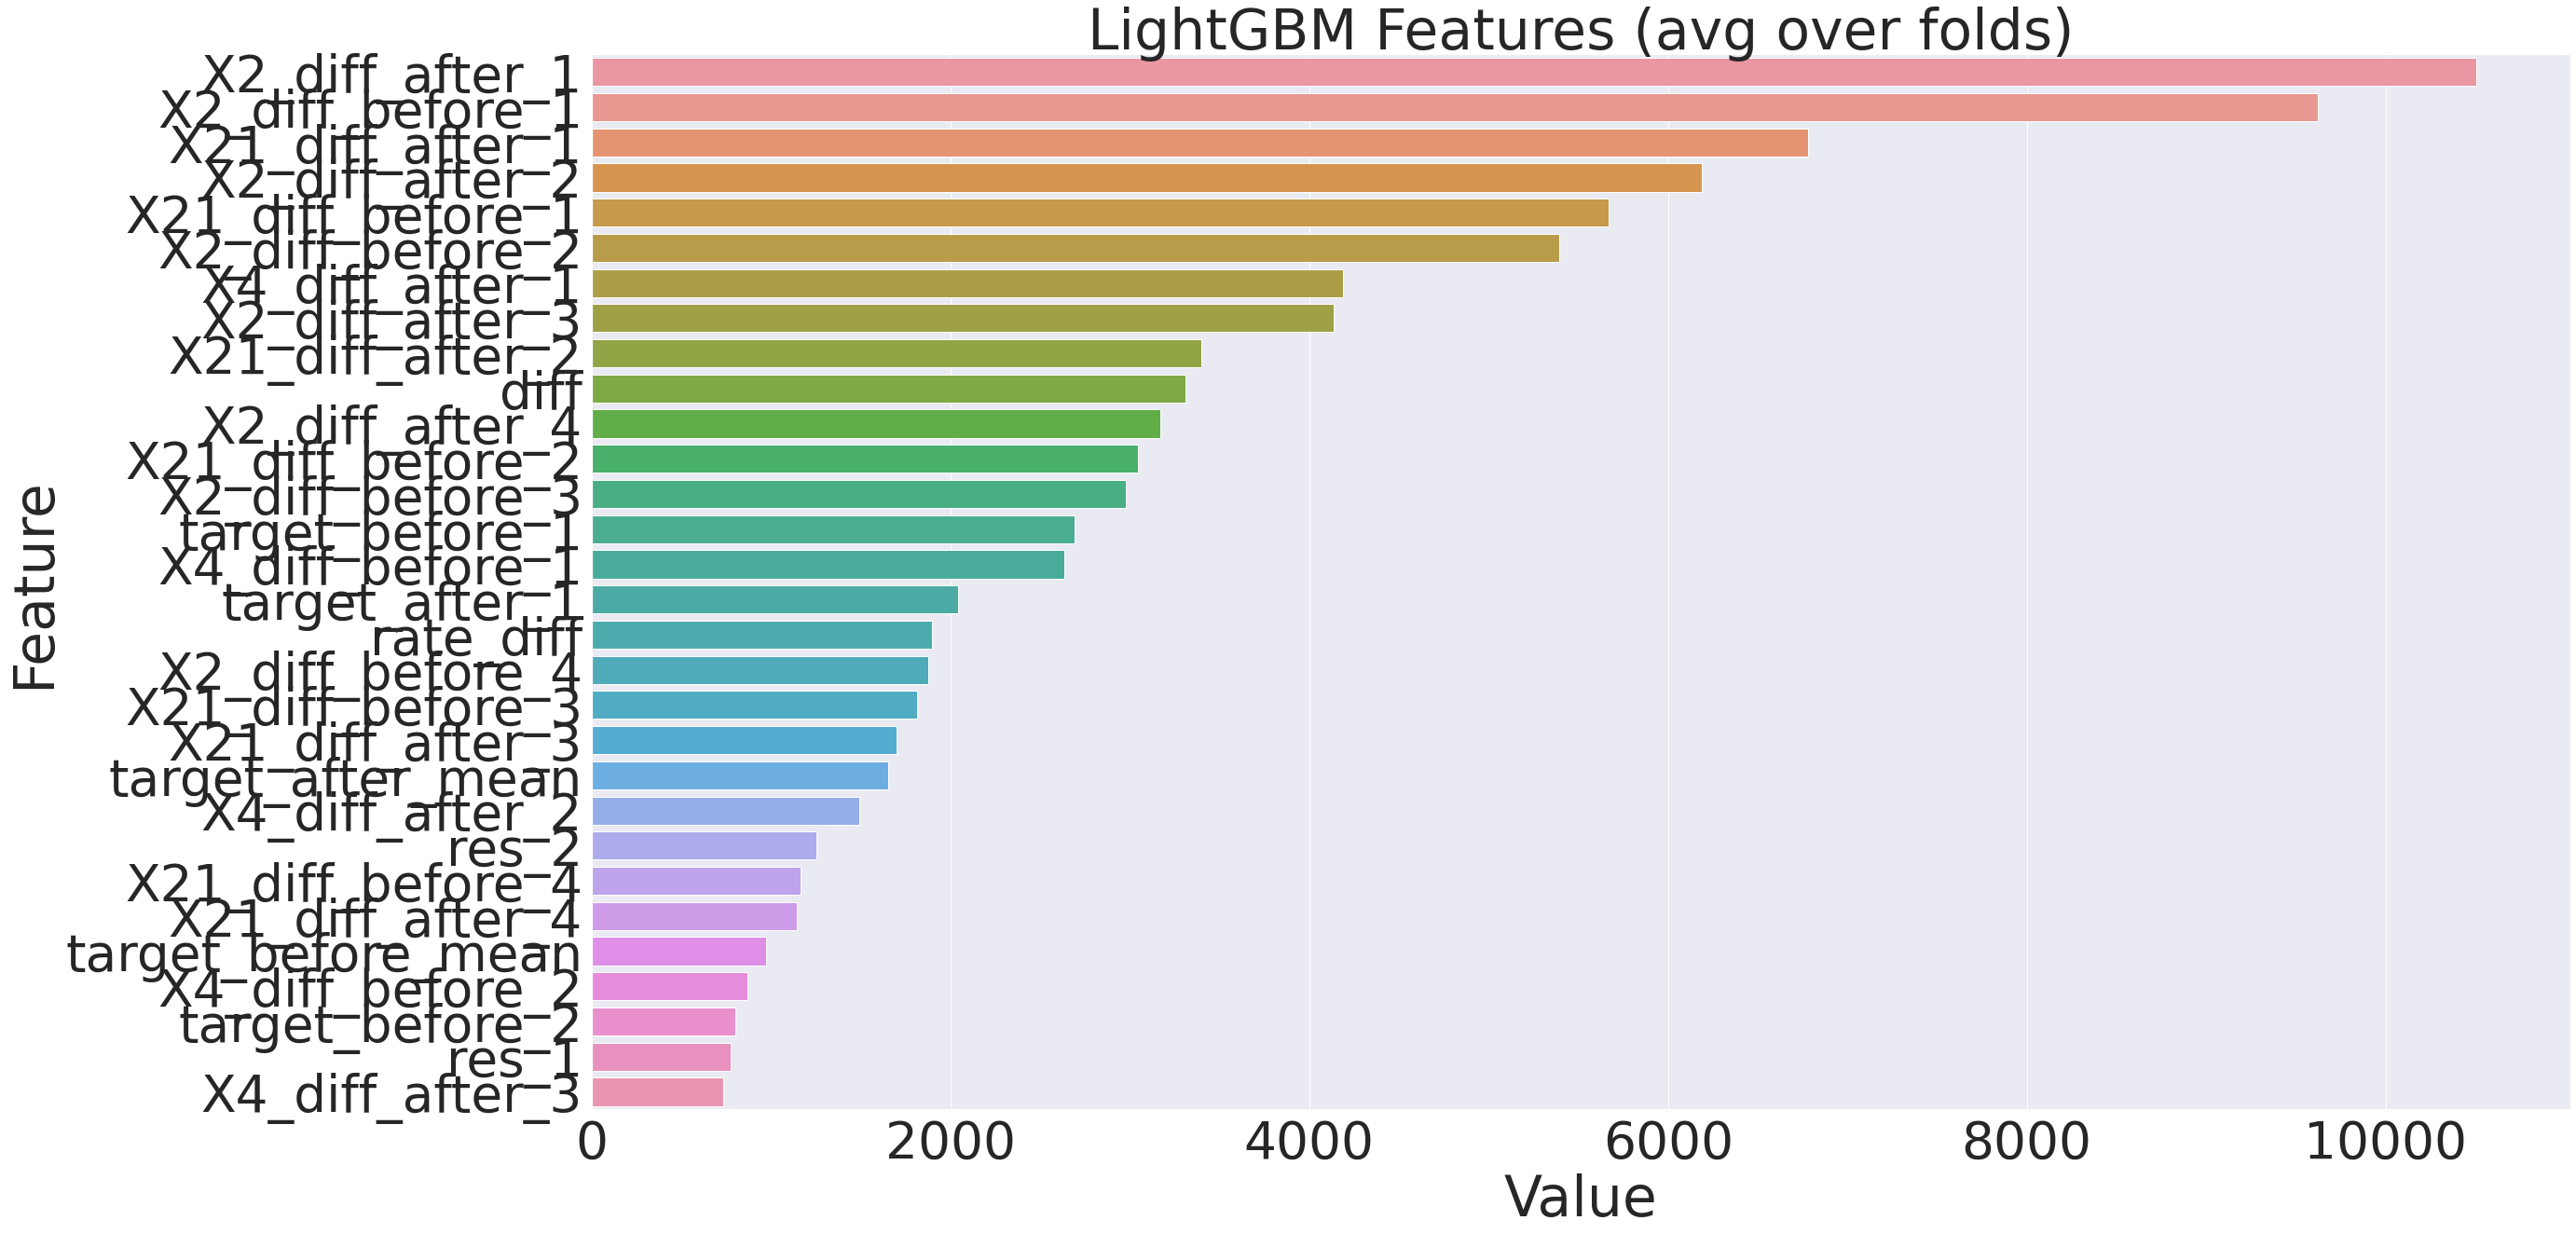

LOGLOSS VALUE 0.5532793099967079


/home/eskender/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.600163	valid_0's binary_logloss: 0.600838
[400]	training's binary_logloss: 0.582489	valid_0's binary_logloss: 0.583308
[600]	training's binary_logloss: 0.573553	valid_0's binary_logloss: 0.574509
[800]	training's binary_logloss: 0.567592	valid_0's binary_logloss: 0.568764
[1000]	training's binary_logloss: 0.563167	valid_0's binary_logloss: 0.564606
[1200]	training's binary_logloss: 0.559737	valid_0's binary_logloss: 0.561542
[1400]	training's binary_logloss: 0.55695	valid_0's binary_logloss: 0.559119
[1600]	training's binary_logloss: 0.554335	vali

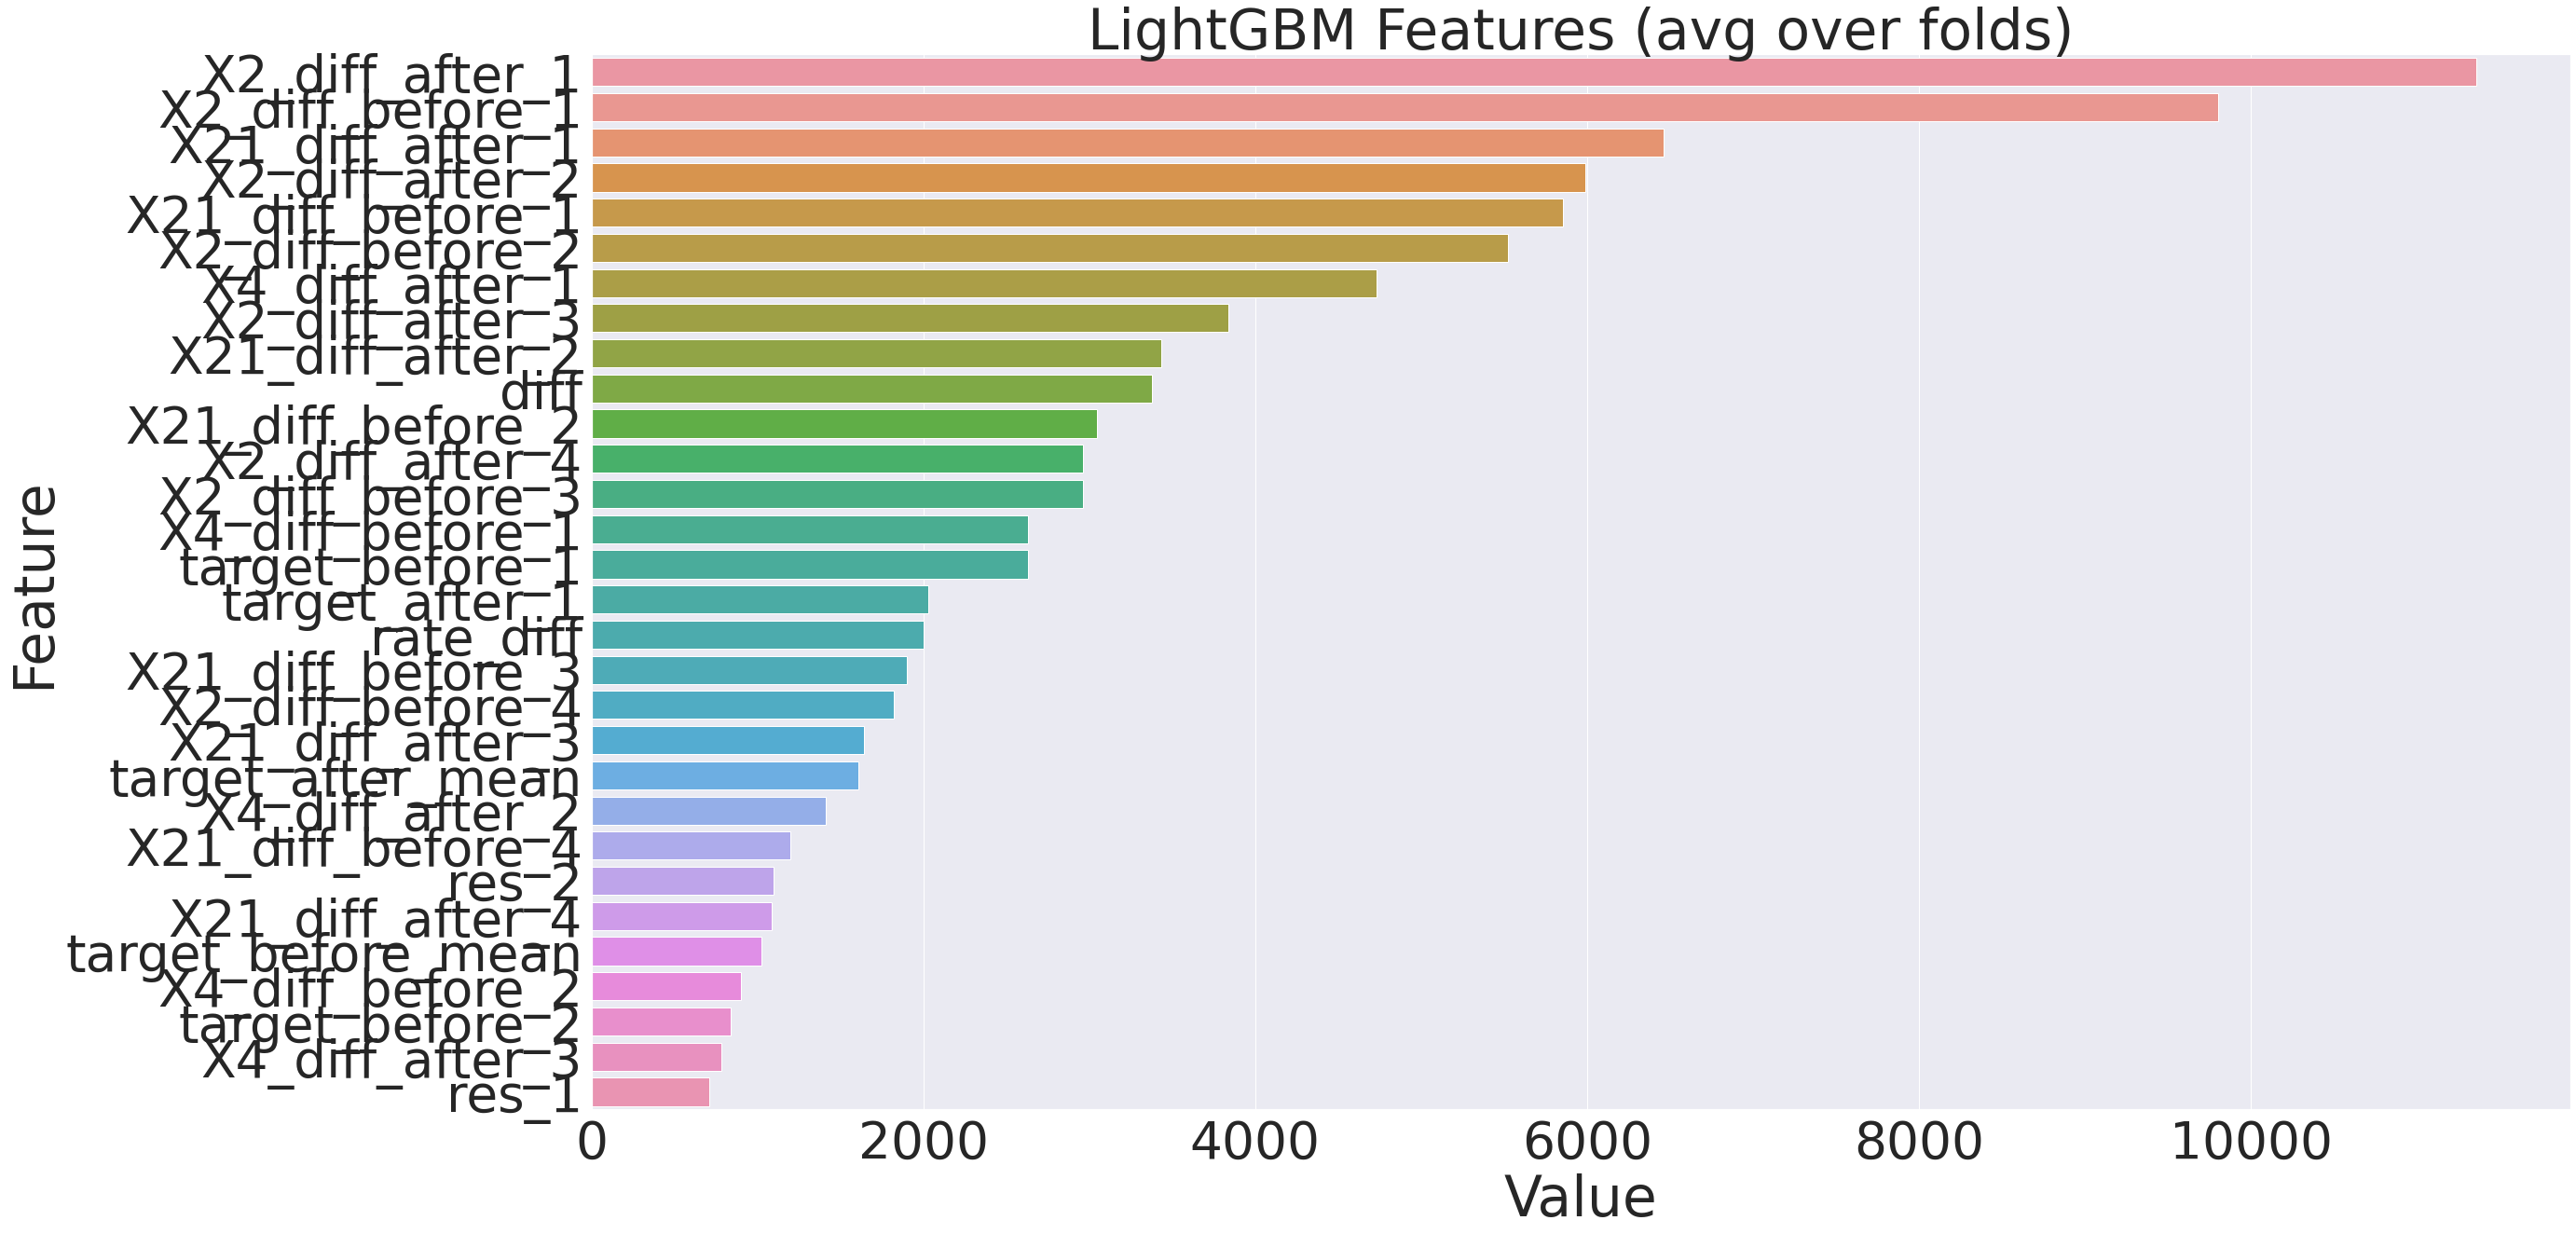

LOGLOSS VALUE 0.5531100012338084


/home/eskender/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 50 rounds
[200]	training's binary_logloss: 0.600087	valid_0's binary_logloss: 0.601006
[400]	training's binary_logloss: 0.582654	valid_0's binary_logloss: 0.583917
[600]	training's binary_logloss: 0.573339	valid_0's binary_logloss: 0.574837
[800]	training's binary_logloss: 0.567831	valid_0's binary_logloss: 0.569631
[1000]	training's binary_logloss: 0.563098	valid_0's binary_logloss: 0.565268
[1200]	training's binary_logloss: 0.559519	valid_0's binary_logloss: 0.562095
[1400]	training's binary_logloss: 0.556695	valid_0's binary_logloss: 0.559656
[1600]	training's binary_logloss: 0.554286	val

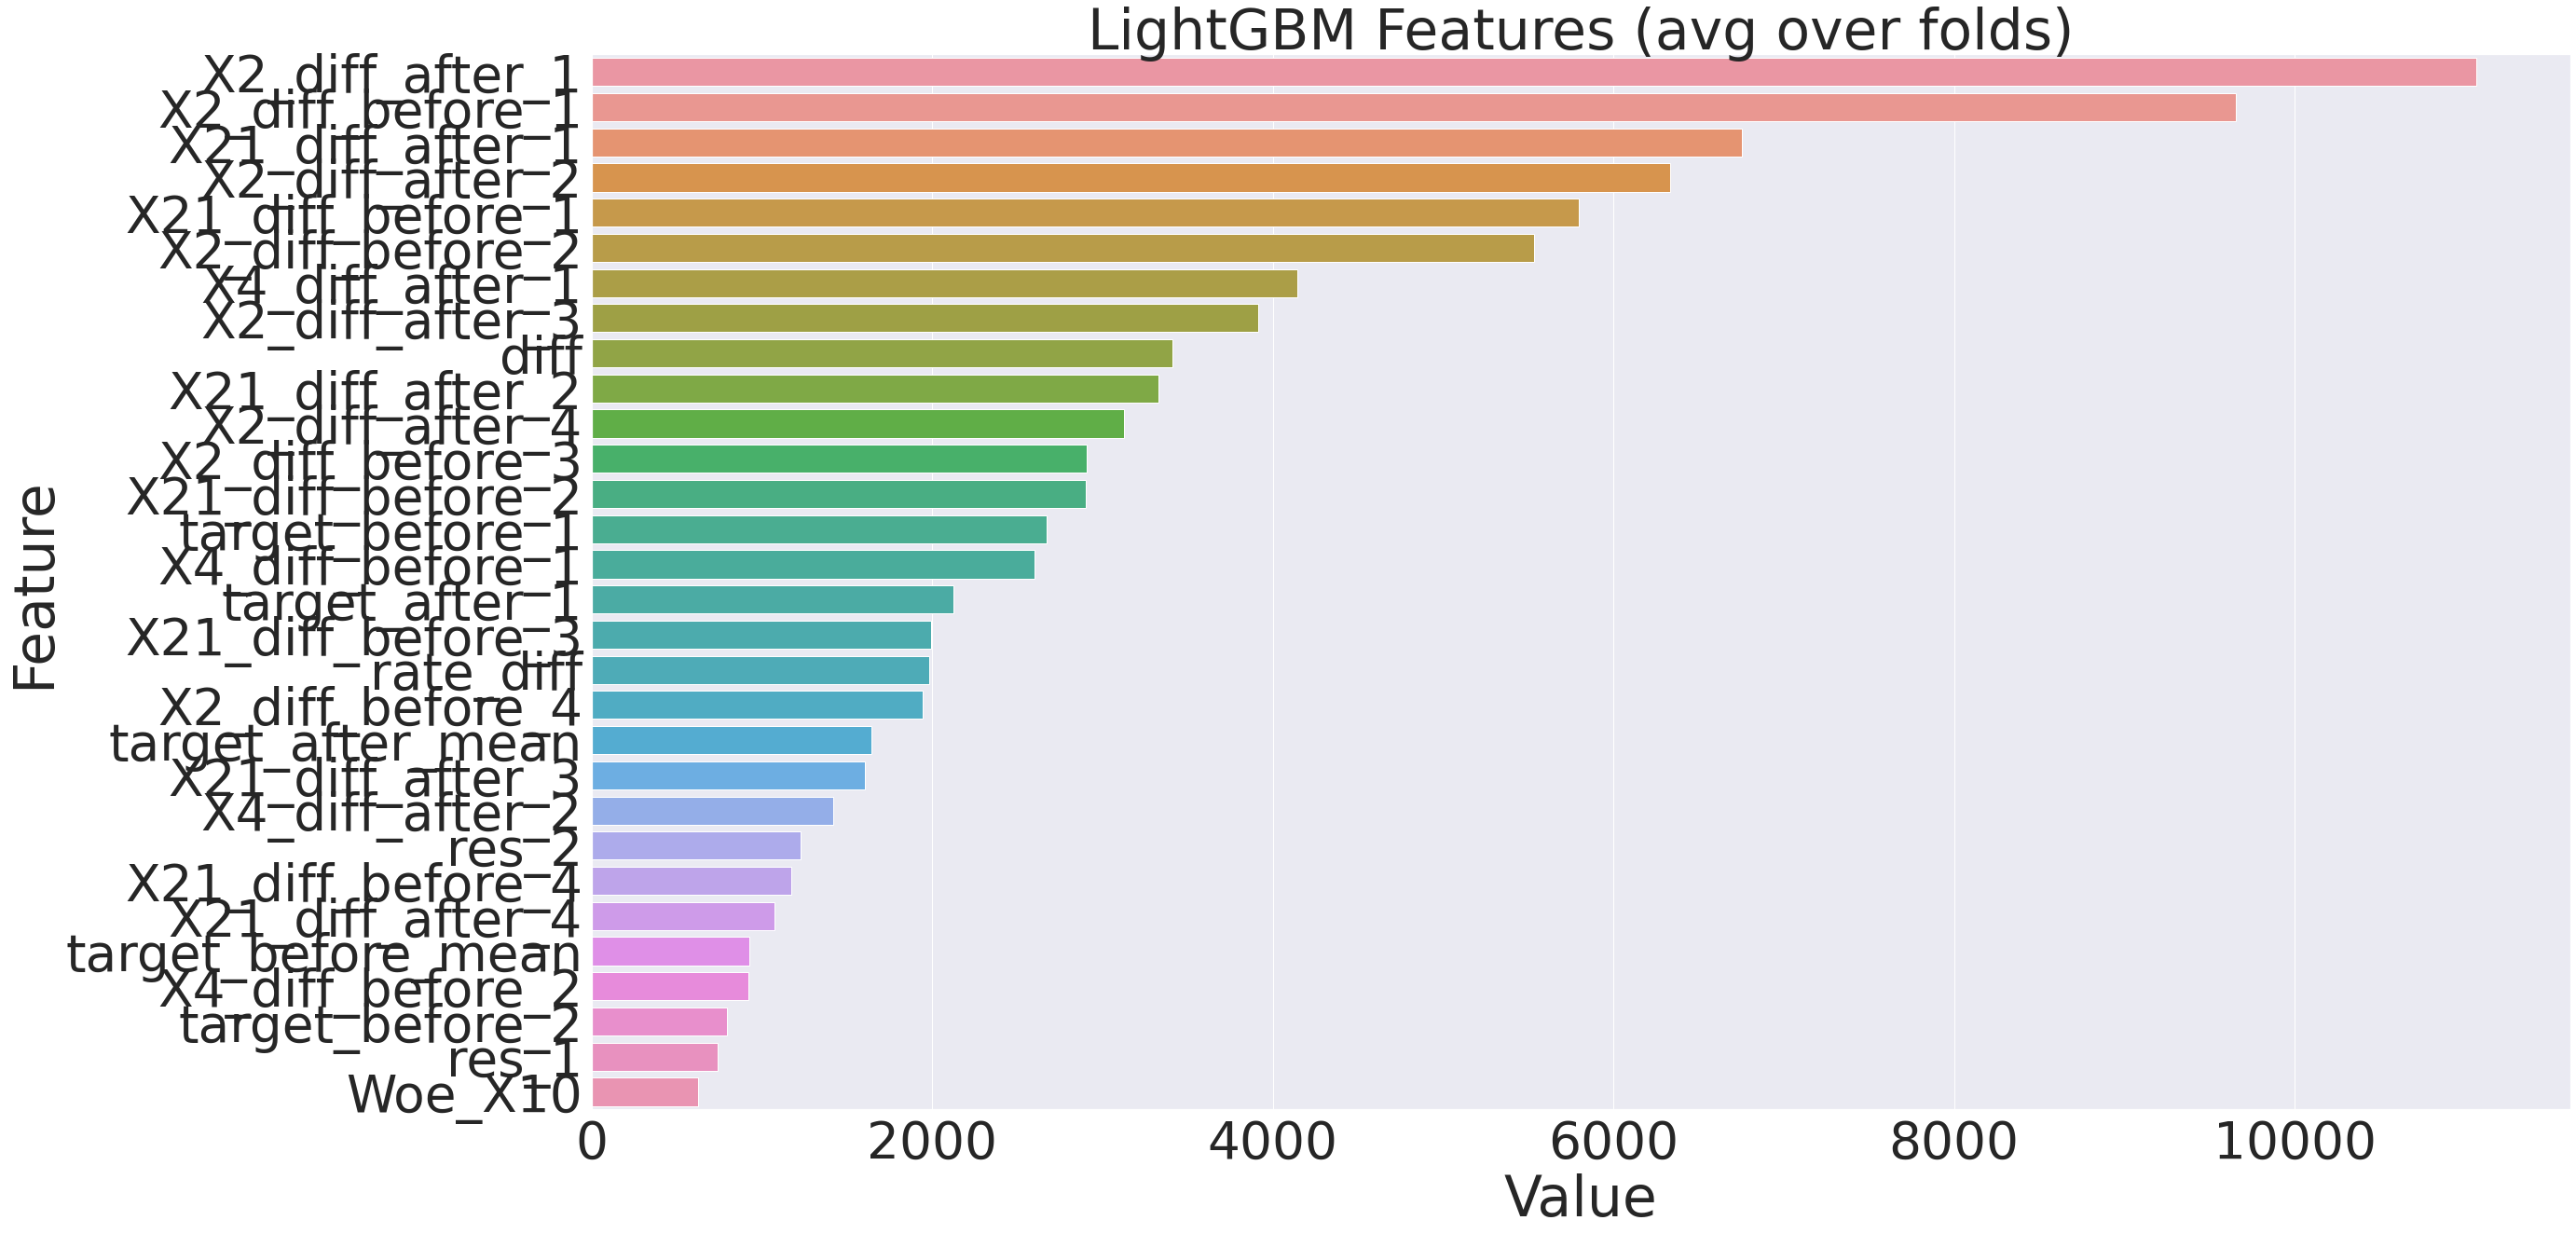

LOGLOSS VALUE 0.5533367056445136


In [23]:
dataframe_test, dataframe_val = sol.prepare_prognosis(params)

In [24]:
def ensemble_predictions(predictions, weights, type_="linear"):
    assert np.isclose(np.sum(weights), 1.0)
    if type_ == "linear":
        res = np.average(predictions, weights=weights, axis=0)
    elif type_ == "harmonic":
        res = np.average([1 / p for p in predictions], weights=weights, axis=0)
        return 1 / res
    elif type_ == "geometric":
        numerator = np.average(
            [np.log(p) for p in predictions], weights=weights, axis=0
        )
        res = np.exp(numerator / sum(weights))
        return res
    elif type_ == "rank":
        res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
        return res / (len(res) + 1)
    return res

In [25]:
weights = [0.2, 0.2, 0.2, 0.2, 0.2]
dataframe_test["target_nn"] = ensemble_predictions(
    [dataframe_test.target_nn_0.values, dataframe_test.target_nn_1.values, dataframe_test.target_nn_2.values,
     dataframe_test.target_nn_3.values,dataframe_test.target_nn_4.values],
    weights,
    type_="linear",
)

In [26]:
# Бленд

weights = [0.2, 0.2, 0.2, 0.2, 0.2]
dataframe_test["target_lgb"] = ensemble_predictions(
    [dataframe_test.target_0.values, dataframe_test.target_1.values, dataframe_test.target_2.values,
     dataframe_test.target_3.values,dataframe_test.target_4.values],
    weights,
    type_="linear",
)

In [27]:
dataframe_test['target'] = dataframe_test["target_nn"]* 0.0 + dataframe_test["target_lgb"]* 1.0

In [28]:
dataframe_test[['id', 'target']].to_csv(os.path.join(OUTPUT_DIR, 'sub_only_lgb_shifter.csv'), index=None)

### The end